### Ed Mwanza  
#### *PhD Researcher - ACIL@S&T*


### Learning to Learn:

#### Templates: Applying Genetic Algorithms to Optimize Neural Networks

gen	nevals	max     	avg     
0  	10    	0.763935	0.654657
1  	5     	0.781481	0.706089
2  	4     	0.798872	0.752789
3  	5     	0.798872	0.730194
4  	5     	0.798872	0.768376
5  	5     	0.798872	0.774271
6  	5     	0.798872	0.779546
7  	3     	0.798872	0.773018
8  	5     	0.798872	0.786304
9  	1     	0.798872	0.792398
10 	4     	0.798872	0.776115
11 	5     	0.798872	0.767713
12 	5     	0.798872	0.782866
13 	5     	0.798872	0.786471
14 	5     	0.798872	0.783623
15 	5     	0.798872	0.788094
16 	4     	0.798872	0.779725
17 	4     	0.801684	0.790979
18 	5     	0.801684	0.784509
19 	5     	0.801684	0.785833
20 	2     	0.801684	0.787712
21 	4     	0.801684	0.787467
22 	5     	0.801684	0.792076
23 	3     	0.801684	0.786716
24 	5     	0.801684	0.785241
25 	5     	0.801684	0.781042
- Best solution is: 
params =  'alpha'=0.014, 'gamma'=0.976, 'rho'=0.782, 'epsilon = 0.552'
Accuracy = 0.80168


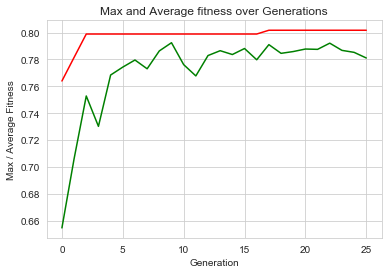

In [2]:
from deap import base
from deap import creator
from deap import tools

import random
import numpy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import neuroevolution
import elitism


BOUNDS_LOW =  [0, 0, 0, 0]
BOUNDS_HIGH = [1, 1, 1, 1]

NUM_OF_PARAMS = len(BOUNDS_HIGH)

# Genetic Algorithm constants:
POPULATION_SIZE = 10
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.5   # probability for mutating an individual
MAX_GENERATIONS = 25
HALL_OF_FAME_SIZE = 5
CROWDING_FACTOR = 20.0  # crowding factor for crossover and mutation

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# create the classifier accuracy test class:
test = neuroevolution.HyperparameterTuningGenetic(randomSeed=RANDOM_SEED)

toolbox = base.Toolbox()

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)

# define the hyperparameter attributes individually:
for i in range(NUM_OF_PARAMS):
    # "hyperparameter_0", "hyperparameter_1", ...
    toolbox.register("hyperparameter_" + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])

# create a tuple containing an attribute generator for each param searched:
hyperparameters = ()
for i in range(NUM_OF_PARAMS):
    hyperparameters = hyperparameters + \
                      (toolbox.__getattribute__("hyperparameter_" + str(i)),)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator",
                 tools.initCycle,
                 creator.Individual,
                 hyperparameters,
                 n=1)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# fitness calculation
def classificationAccuracy(individual):
    return test.getAccuracy(individual),

toolbox.register("evaluate", classificationAccuracy)

# genetic operators:mutFlipBit

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0 / NUM_OF_PARAMS)


# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", numpy.max)
    stats.register("avg", numpy.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population,
                                                      toolbox,
                                                      cxpb=P_CROSSOVER,
                                                      mutpb=P_MUTATION,
                                                      ngen=MAX_GENERATIONS,
                                                      stats=stats,
                                                      halloffame=hof,
                                                      verbose=True)

    # print best solution found:
    print("- Best solution is: ")
    print("params = ", test.formatParams(hof.items[0]))
    print("Accuracy = %1.5f" % hof.items[0].fitness.values[0])

    # extract statistics:
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()


if __name__ == "__main__":
    main()